<a href="https://colab.research.google.com/github/ram-sharanga/amdocs/blob/main/tranquil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [ ]:
import pandas as pd

In [ ]:
from datasets import load_dataset

emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

In [ ]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [ ]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

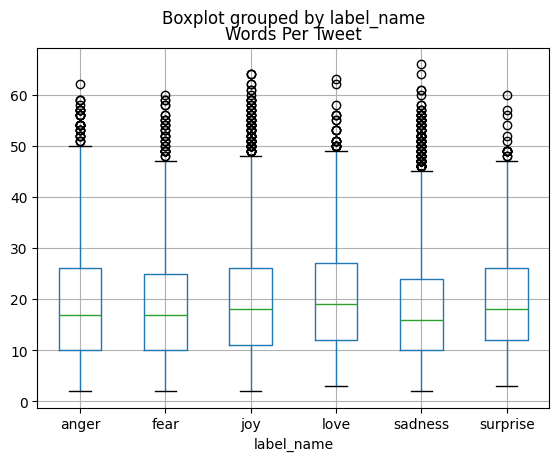

In [ ]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by='label_name')

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
text = "I love Machine Learning!. Tokenization is awesome"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [ ]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

In [ ]:
emotion.reset_format()

In [ ]:
def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(emotion["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [ ]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
text

'I love Machine Learning!. Tokenization is awesome'

In [ ]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2293,  3698,  4083,   999,  1012, 19204,  3989,  2003,
         12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
with torch.no_grad():
  outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
last_hidden_states.shape

torch.Size([1, 12, 768])

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device

device(type='cuda')

In [ ]:
from transformers import TrainingArguments

In [ ]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                 weight_decay=0.01,
                                 eval_strategy = 'epoch',
                                 disable_tqdm=False,
                                 report_to='none')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

<ipython-input-49-731d64f15024>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.315099,0.908500,0.907867
2,0.547800,0.220280,0.921500,0.921529


TrainOutput(global_step=500, training_loss=0.5477850952148438, metrics={'train_runtime': 235.6863, 'train_samples_per_second': 135.774, 'train_steps_per_second': 2.121, 'total_flos': 720342861696000.0, 'train_loss': 0.5477850952148438, 'epoch': 2.0})

In [ ]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.22446906566619873,
 'test_accuracy': 0.917,
 'test_f1': 0.9162265286395147,
 'test_runtime': 3.4025,
 'test_samples_per_second': 587.803,
 'test_steps_per_second': 9.405}

In [ ]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       581
           1       0.94      0.94      0.94       695
           2       0.78      0.81      0.80       159
           3       0.92      0.92      0.92       275
           4       0.88      0.89      0.88       224
           5       0.80      0.61      0.69        66

    accuracy                           0.92      2000
   macro avg       0.88      0.86      0.86      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
text = 'i love u'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
classes[pred]

'love'

In [ ]:
import shutil
from google.colab import files

shutil.make_archive("distilbert-finetuned-emotion", 'zip', "distilbert-finetuned-emotion")
files.download("distilbert-finetuned-emotion.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
checkpoint_path = "./distilbert-finetuned-emotion/checkpoint-500"
model_loaded = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
text_input = "I am feeling really angry today!"
inputs = tokenizer(text_input, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model_loaded(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=-1).item()

classes = ["sadness", "joy", "love", "anger", "fear", "surprise"]
predicted_label = classes[predicted_class]

print(f"Predicted emotion: {predicted_label}")

Predicted emotion: anger
